## Import Required Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from scipy.fft import fft2, ifft2, fftshift
import os
from IPython.display import clear_output
import time


## Load the gc_periodic function

Import the main simulation function from the converted Python file.

In [3]:
# Import the gc_periodic function
from gc_periodic import gc_periodic

## Initialize Network Parameters

**Warning:** The following are the parameters used in the associated paper. Altering them will likely lead to an unsuccessful simulation.

In [ ]:
# Timestep in ms
dt = 0.5

# Number of neurons (must be power of 2)
n = 2**7 # 128 neurons

# Neuron time-constant (in ms)
tau = 5


modules = [1, 2, 3, 4]  # List of active modules


def set_module_params(module_number):
    """Set parameters based on module number."""
    scale_factor = 1.4 ** (module_number - 1)
    
    # Envelope and Weight Matrix Parameters
    lambda_param = 13 * scale_factor  # Equation (3)
    beta = 3 / lambda_param**2  # Equation (3)
    alphabar = 1.05
    gamma = alphabar * beta  # alphabar = gamma/beta from Equation (3)
    a =  1 # a should be <= alphabar^2. Equation (3)
    wtphase = 2  # wtphase is 'l' from Equation (2)
    alpha = 1 / scale_factor  # The velocity gain from Equation (4
    
    return beta, gamma, a, wtphase, alpha


# Simulation options
useSpiking = False  # Set to True for spiking model, False for rate model
filename = 'trajectory_data.npz'  # Path to trajectory data (will use random if not found)

# print("Network Parameters:")
# print(f"  Number of neurons: {n} x {n}")
# print(f"  Time constant: {tau} ms")
# print(f"  Time step: {dt} ms")
# print(f"  Beta: {beta:.6f}")
# print(f"  gamma: {gamma}")
# print(f"  A bar: {abar}")
# print(f"  Weight phase: {wtphase}")
# print(f"  Velocity gain: {alpha}")
# print(f"  Spiking model: {useSpiking}")

In [29]:
# Run the simulation
print("Starting simulation...")
print("This may take several minutes depending on trajectory length.\n")

MODULE = 1

# # Run the simulation for each module
# for MODULE in modules:
#     print(f"Simulating Module {MODULE}...")
#         spikes = gc_periodic(
#             filename=filename,
#             n=n,
#             tau=tau,
#             dt=dt,
#             beta=beta,
#             gamma=gamma,
#             abar=abar,
#             wtphase=wtphase,
#             alpha=alpha,
#             useSpiking=useSpiking,
#             module=MODULE
#         )

beta, gamma, abar, wtphase, alpha = set_module_params(MODULE)

spikes, integrated_path_x_cm, integrated_path_y_cm, error, position_x, position_y = gc_periodic(
    filename=filename,
    n=n,
    tau=tau,
    dt=dt,
    beta=beta ,
    gamma=gamma,
    abar=abar,
    wtphase=wtphase,
    alpha=alpha,
    useSpiking=useSpiking,
    module = MODULE,
    GET_BAND=False,
    BAND_ANGLE=30,
    duration=5000
)

print("\nSimulation complete!")

Starting simulation...
This may take several minutes depending on trajectory length.



100%|██████████| 4980/4980 [00:04<00:00, 1164.93it/s]


Optimized Scale Factor: 2.2695
X Offset: -12.51, Y Offset: 3.70
[  0.           0.20920637   0.43770803 ... 134.34144542 134.34144542
 134.31805215] [-12.51299882 -12.51299882 -12.51299882 ... -12.51299882 -12.51299882
 -12.51299882]
Debug plot saved to: plots/simulation/module_1/debug_path_integration_mod1.png
Error plot saved to: plots/simulation/module_1/error_over_time_mod1.png

Simulation complete!


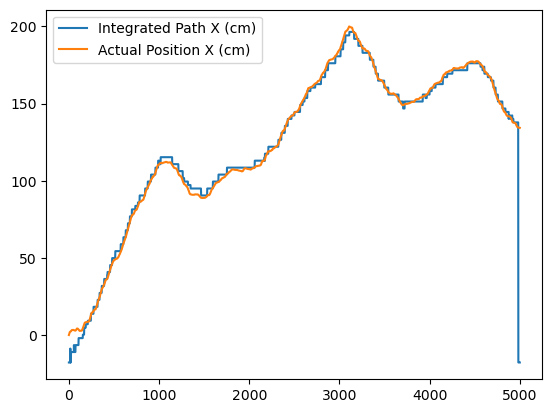

In [26]:
plt.plot(integrated_path_x_cm, label='Integrated Path X (cm)')
plt.plot(position_x, label='Actual Position X (cm)')
plt.legend()

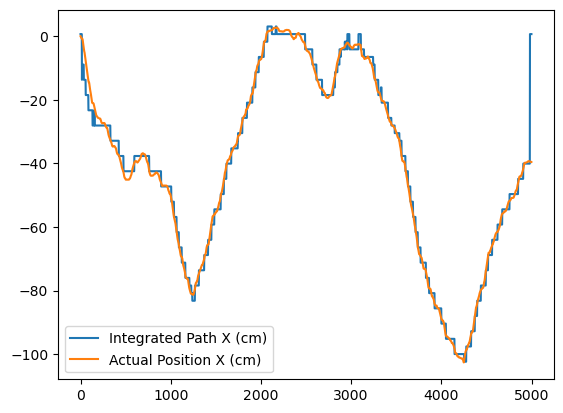

In [27]:
plt.plot(integrated_path_y_cm, label='Integrated Path X (cm)')
plt.plot(position_y, label='Actual Position X (cm)')
plt.legend()

## Analyze Results

If spiking model was used, analyze the spike data.

In [31]:
# if useSpiking and spikes is not None:
#     # Count total spikes over time
#     spike_counts = []
#     for spike_matrix in spikes:
#         if spike_matrix is not None:
#             spike_counts.append(np.sum(spike_matrix))
#         else:
#             spike_counts.append(0)
    
#     # Plot spike count over time
#     plt.figure(figsize=(12, 4))
#     plt.plot(spike_counts)
#     plt.xlabel('Time step')
#     plt.ylabel('Total spikes in population')
#     plt.title('Population Spiking Activity Over Time')
#     plt.grid(True, alpha=0.3)
#     plt.show()
    
#     print(f"Total simulation steps: {len(spikes)}")
#     print(f"Average spikes per timestep: {np.mean(spike_counts):.2f}")
#     print(f"Max spikes in single timestep: {np.max(spike_counts):.0f}")
# else:
#     print("Rate-based model used (no spike data). See visualizations from simulation above.")

## Quick Test with Smaller Grid (Optional)

For faster testing, you can run a smaller simulation:

In [ ]:
# Uncomment to run a quick test with smaller parameters
# print("Running quick test with n=64...")
# spikes_test = gc_periodic(
#     filename='nonexistent.npz',  # Will use random trajectory
#     n=64,
#     tau=tau,
#     dt=dt,
#     beta=beta,
#     alphabar=alphabar,
#     abar=abar,
#     wtphase=wtphase,
#     alpha=alpha,
#     useSpiking=False
# )